In [38]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

from itertools import cycle, islice
from sklearn import metrics

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# Assignment

Use the [clustering] tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. 

# What I will do

I will use this dataset as an opportunity to discuss challenges of using clustering algorithms. The main reasons are as follows:

1. most of the useful data (time to different markers) is highly correlated and its distrubution is unimodal. It is therefore not ameanable to clustering

2. a lot of the rest of the data is categorical in nature and cannot be clustered without some assumptions, which don't really make sense.

In [39]:
bmData = pd.read_csv('BostonMarathon2014.csv')

In [40]:
bmData.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [41]:
# drop some features that are either nan or are not important for the clustering algorithm

dropCols = ['name', 'ctz' ,'state', 'city', 'division', 'bib','genderdiv', 'overall','gender']
bmData.drop(dropCols, axis=1, inplace=True)

In [42]:
bmData.head()

,10k,25k,age,official,35k,pace,30k,5k,half,20k,country,40k
0,17.37,47.67,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,JPN,80.43
1,32.58,82.43,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,KEN,132.10
2,16.62,45.80,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,RSA,76.10
3,32.57,82.43,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,ETH,132.95
4,17.12,46.37,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,JPN,76.72


For future reference, let us also turn the country data into numbers.

In [43]:
countries = list(bmData['country'].unique())

bmData4 = bmData.copy()
for c, ii in zip(countries, range(1,1+len(countries))):
    bmData4.replace(to_replace=c, value=ii*100, inplace=True)

In [44]:
bmData4.head()

,10k,25k,age,official,35k,pace,30k,5k,half,20k,country,40k
0,17.37,47.67,47,85.25,71.40,3.27,59.18,8.02,39.72,37.65,100,80.43
1,32.58,82.43,33,138.95,116.37,5.30,99.33,16.22,69.47,65.83,200,132.10
2,16.62,45.80,41,80.60,67.42,3.08,56.45,7.75,38.03,36.10,300,76.10
3,32.57,82.43,24,140.58,116.37,5.37,99.33,16.20,69.47,65.83,400,132.95
4,17.12,46.37,40,81.23,67.83,3.10,57.03,8.02,38.60,36.58,100,76.72


A couple of utilities to turn the data into float

In [45]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [46]:
def convertToFloat(df):
    df2 = df.copy()
    df2_check = df2.applymap(lambda x: isfloat(x))
    wrongType = np.where(df2_check==False)
    df2.drop(wrongType[0], axis=0, inplace=True)
    df3 = df2.applymap(lambda x: float(x))
    
    return df3

# Does clustering make sense?

What can we cluster in this data set? Most of the data is time data and we can try to cluster that.

In [47]:
X = convertToFloat(bmData4)

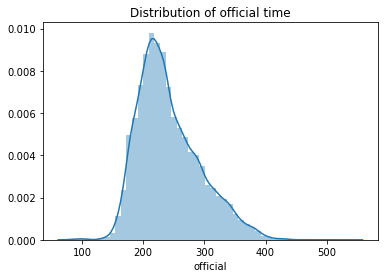

In [48]:
sns.distplot(X['official'])
plt.title('Distribution of official time')
plt.show()

As we can see this is a unimodal distribution. Moreover, the other times are highly correlated to the official time.

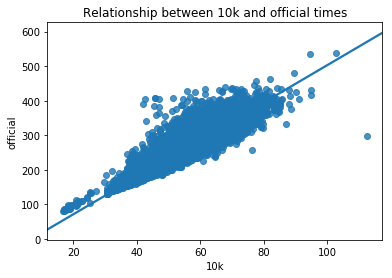

In [49]:
sns.regplot(x='10k', y='official', data=X)
plt.title('Relationship between 10k and official times')
plt.show()

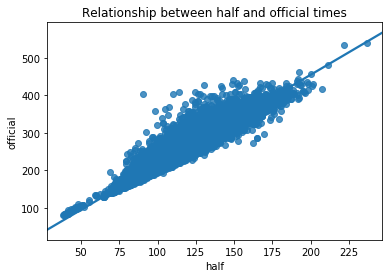

In [50]:
sns.regplot(x='half', y='official', data=X)
plt.title('Relationship between half and official times')
plt.show()

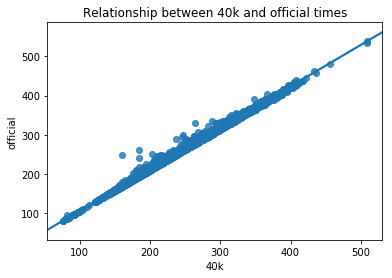

In [51]:
sns.regplot(x='40k', y='official', data=X)
plt.title('Relationship between 40k and official times')
plt.show()

As a consequence, any attempt to run a clustering algorithm will give relatively arbitrary results. There just aren't clusters in this data.

Let's cluster by 'official' time.

In [52]:
X2 = X['official'].values.reshape(-1,1)
model2 = KMeans(n_clusters=3, random_state=42).fit(X2)
y2 = model2.predict(X2)

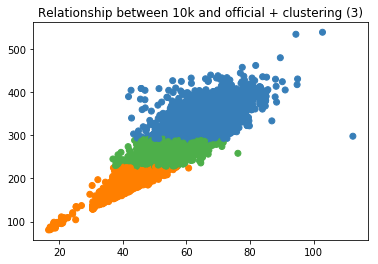

In [53]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y2) + 1))))
plt.scatter(X['10k'],X['official'], color=colors[list(y2)])
plt.title('Relationship between 10k and official + clustering (3)')
plt.show()

Let's increase the number of clusters.

In [54]:
y2 = KMeans(n_clusters=15, random_state=42).fit_predict(X2)

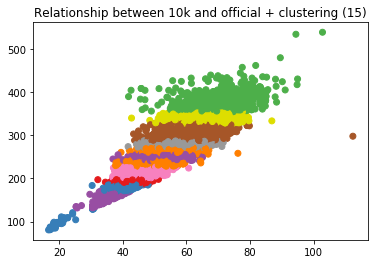

In [55]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y2) + 1))))
plt.scatter(X['10k'],X['official'], color=colors[list(y2)])
plt.title('Relationship between 10k and official + clustering (15)')
plt.show()

We can try to use a couple of the features to cluster.

In [56]:
X2 = X[['official','10k']].values
model2 = KMeans(n_clusters=3, random_state=42).fit(X2)
y2 = model2.predict(X2)

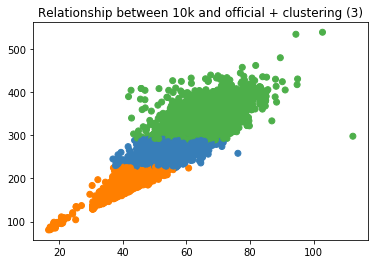

In [57]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y2) + 1))))
plt.scatter(X['10k'],X['official'], color=colors[list(y2)])
plt.title('Relationship between 10k and official + clustering (3)')
plt.show()

In [58]:
y2 = KMeans(n_clusters=15, random_state=42).fit_predict(X2)

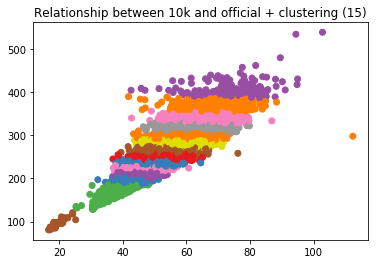

In [59]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y2) + 1))))
plt.scatter(X['10k'],X['official'], color=colors[list(y2)])
plt.title('Relationship between 10k and official + clustering (15)')
plt.show()

Whether we add other times to te features doesn't make much of a difference. The reason is all of these variable are very correlated. On top of that their principal component is unimodal. 

# What do we do about categorical variables?

The problem with categorical variables is that they don't have a comparable scale with the race times numbers. We can try to look at the variable 'age' because, although categorical, it is made of numbers and there exists a meaningful concept of difference of age.

In [60]:
X3 = X[['official','age']].values
y3 = KMeans(n_clusters=5, random_state=42).fit_predict(X3)

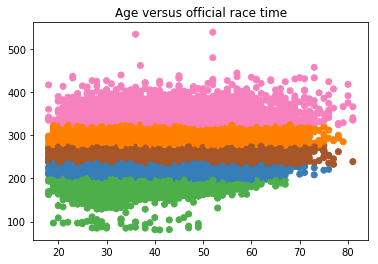

In [61]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y3) + 1))))
plt.scatter(X['age'].values, X['official'].values, color=colors[list(y3)])
plt.title('Age versus official race time')
plt.show()

This picture shows that if we try to cluster by the variables official (race time) and age we more or less get a clustering dominated by official. Mainly because it has a different large scale. Not to talk about the fact that the clusters aren't really meaningful (as we saw above). 

Problems are even bigger if we try to add a non-number categorical variable like country (which I transformed above into numbers where each country gets multiple of 100). 

The data looks like this

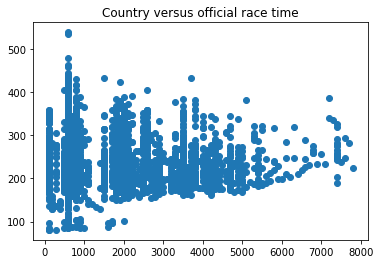

In [62]:
plt.scatter(X['country'],X['official'])
plt.title('Country versus official race time')
plt.show()

We can see the data "clustered" at multiples of 100 (each one standing for a different country). But if we try to run a clustering algorithm ...

In [63]:
X4 = X[['country','official']].values
y4 = KMeans(n_clusters=40, random_state=42).fit_predict(X4)

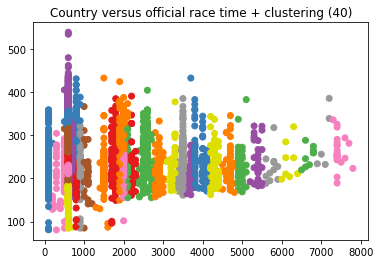

In [64]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y4) + 1))))
plt.scatter(X['country'],X['official'], color=colors[list(y4)])
plt.title('Country versus official race time + clustering (40)')
plt.show()

We will be tempted to say "great job. it found a lot of the countries". Well, it did so because I gave it a large enough number of countries. I could have guessed fewer countries and gotten even more garbage.

In [65]:
y5 = KMeans(n_clusters=10, random_state=42).fit_predict(X4)

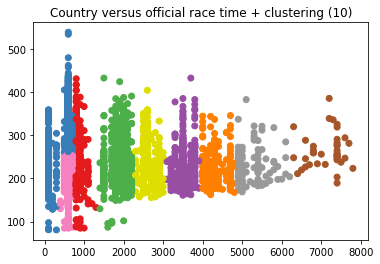

In [66]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),
                                          int(max(y5) + 1))))
plt.scatter(X['country'],X['official'], color=colors[list(y5)])
plt.title('Country versus official race time + clustering (10)')
plt.show()

This is garbage because many countries get lumped together and distance between these countries is small on my x-axis (due to my relatively arbitrary integer labels), but these countries are not close in any meaningful sense of the word.

# Some conclusions

However much I would like to make some nice clustering charts with this data, the reality is that there doesn't seem to be much one can cluster. Some of the data is not clustering appropriate because distance does not exist (e.g. country) and the rest of the data is not appropriate because it is all highly correlated to one factor (e.g. official race time) and that one factor doesn't display any meaningful clusters. 


# Questions

1. Am I missing something?
2. I tried using SpectralClustering and my computer died. The data set has about 30K samples in it. Mean Shift is also very slow (quadratic in number of samples). What do you do when your data set is huge? 